# Statistical and Spatial Analysis of the Apartment Segment in the Spanish Real Estate Market (2019) - Geolocalization

#### Obtain the full address, region, province, city, and coordinates through geolocation and integration of external data.

For this process, we use the **geopy** library, a Python client for several popular geocoding web services. To have this library available, we need to install it via **pip** in the Bash terminal or directly in a Jupyter Notebook cell.

```python
    pip install geopy
```

Import the geocoder to be used; in this case, we will use **Nominatim**, an Open Source geolocator that utilizes OpenStreetMap.



In [79]:
# Import libraries
import requests
import numpy as np
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# my functions
from scripts.functions import *

# Import the geocoder
from geopy.geocoders import Nominatim

# Error handling
from geopy.exc import GeocoderTimedOut, GeocoderServiceError

# Set Pandas to Display All Columns
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format

#### Split the dataframe into chunks to optimize memory and execution time.

Given the file’s size, geolocating all entries at once would be inefficient and could lead to memory issues and very high processing time. To mitigate this, the file is **divided into chunks of 10,000 rows**. The create_chunks function is designed to split the DataFrame, save each chunk to disk, and generate a list of the file names.

In [2]:
def create_chunks(df, chunksize, directory):
    file_names = []
    chunk_number = 0

    # Iterar sobre el DataFrame en trozos de tamaño específico
    for start in range(0, len(df), chunksize):
        chunk_number += 1
        chunk = df[start:start + chunksize]
        # Guardar el chunk en un archivo CSV
        file_name = f'{directory}/dataframe_{chunk_number}.csv'
        chunk.to_csv(file_name, index=False)
        file_names.append(file_name)
        # Liberar memoria
        del chunk
        gc.collect()

    return file_names

#### Declare variables and execute functions

In [10]:
# Output directory
directory = 'data/'

# Input File
df = pd.read_csv('data/clean_data.csv')

# Chunks Size
chunksize = 10000

# chunks_files = create_chunks(input_csv, chunksize, directory)
# print(chunks_files)

#### Obtaining Latitude and Longitude

The **geolocate** function takes the full address from the `loc_full` variable, attempts to geocode it, and returns the latitude and longitude. If there is an issue, it will try with the `city_prov` variable, which only includes the city and province. It will return `None` if neither of the two variables is successful. Between each iteration with the geolocator, it will wait for 1 second, which is the minimum time for each request with this geolocator. The function includes:

- A loop to retry geolocation up to a maximum number of retries.
- A 10-second timeout for each geolocation attempt, as set in the **geopy** configuration.
- Error handling that includes a `time.sleep` with a `backoff_factor` to increase the wait time between retries.

In [ ]:
def geolocate(row, geolocator, retries=retries, backoff_factor=backoff_factor, timeout=timeout):
    address = row['loc_full']
    address_2 = row['city_prov']

    for attempt in range(retries):
        try:
            location = geolocator.geocode(address, timeout=timeout)
            if not location:
                time.sleep(1)
                location = geolocator.geocode(address_2, timeout=timeout)

            if location:
                return pd.Series([location.latitude, location.longitude, location.address])
            else:
                return pd.Series([None, None, None])
        except (GeocoderTimedOut, GeocoderServiceError) as e:
            print(f"Error geocoding {address} or {address_2}: {e}")
            time.sleep(backoff_factor * (2 ** attempt))
    return pd.Series([None, None, None])

The **split_address** function extracts the `postal code`, `region`, and `municipality` from the address provided by the geolocation.

In [5]:
def split_address(df, address_col):
    df = df.copy()
    p_codes = []
    regions = []
    municipalities = []

    for address in df[address_col]:
        if address:
            parts = address.split(', ')
            if len(parts) >= 3:
                possible_p_code = parts[-2]

                if len(possible_p_code) == 5 and possible_p_code.isdigit():
                    p_code = possible_p_code
                    region = parts[-3]
                    municipality = parts[-4]
                else:
                    p_code = None
                    region = parts[-2]
                    municipality = parts[-3]
            else:
                p_code = None
                region = None
                municipality = None
        else:
            p_code = None
            region = None
            municipality = None

        p_codes.append(p_code)
        regions.append(region)
        municipalities.append(municipality)

    df['p_code'] = p_codes
    df['region'] = regions
    df['municipality'] = municipalities

    return df

The **process_chunk** function generates the new data columns created with **geolocate** and **split_address** function and adds them to the section of the dataframe being processed, then saves it to a CSV file. It then frees the created dataframe from memory and forces garbage collection. This method ensures that the memory used by the dataframe is released after saving, helping to maintain efficient memory usage when processing large volumes of data.

In [7]:
def process_chunk(chunk_file, directory, geolocator):
    df_chunk = pd.read_csv(chunk_file)
    location_data = []

    for idx, row in df_chunk.iterrows():
        location_data.append(geolocate(row, geolocator))
        time.sleep(1)
    df_chunk[['latitude', 'longitude', 'address']] = pd.DataFrame(location_data)
    df_chunk = split_address(df_chunk, 'address')

    # Save dataframe
    processed_file_name = f'{directory}/processed_{chunk_file.split("/")[-1]}'
    df_chunk.to_csv(processed_file_name, index=False)

    # Free memory
    del df_chunk
    gc.collect()

    return processed_file_name

#### Define Variables and Execute Functions

In [9]:
# Define geolocator
# geolocator = Nominatim(user_agent="spanish_houses")

# Funtions parameters
retries = 3
backoff_factor = 0.3
timeout = 10

# Define variables
directory = 'data/chunks/'

# Execute functions to obtain Latitude and Longitude
#  process_chunk('data/chunks/dataframe_1.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_2.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_3.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_4.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_5.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_6.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_7.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_8.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_9.csv', directory, geolocator)
#  process_chunk('data/chunks/dataframe_10.csv', directory, geolocator)

### Saving Geolocalized Data

In [10]:
processed_files = ['data/chunks/processed_dataframe_1.csv',
                   'data/chunks/processed_dataframe_2.csv',
                   'data/chunks/processed_dataframe_3.csv',
                   'data/chunks/processed_dataframe_4.csv',
                   'data/chunks/processed_dataframe_5.csv',
                   'data/chunks/processed_dataframe_6.csv',
                   'data/chunks/processed_dataframe_7.csv',
                   'data/chunks/processed_dataframe_8.csv',
                   'data/chunks/processed_dataframe_9.csv',
                   'data/chunks/processed_dataframe_10.csv']

# dataframes = [pd.read_csv(file) for file in processed_files]
# processed_dataframe = pd.concat(dataframes, ignore_index=True)

# Save the dataframe
# processed_dataframe.to_csv('data/processed_dataframe.csv', index=False)

### Coordinate Fluctuation (Jittering)

**Jittering** is a technique used to slightly disperse points that have identical or very similar coordinates, making data visualization and analysis easier. To perform Jittering, a small amount of random noise is added to the coordinates of each point to disperse them slightly. The **move_coordinates** function moves the coordinates by a random angle and distance provided by the **disperse_coordinates** function. This random angle and distance are converted into latitude and longitude degrees, which are then added to the original coordinates. In this way, multiple properties with the same coordinates will be separated by different distances and angles from the original point. One disadvantage of using this technique is that when the location is near the coast, it may result in locations appearing over the sea.

The **disperse_coordinates** function first groups all the duplicate coordinates and applies the **move_coordinates** function to each line with a different angle and distance value within the ranges specified in the parameters.

In our project, properties that share the same coordinates are because:
- In the case of buildings.
- if the address was not in the correct format, the geolocation function used the 'city_prov' variable, geolocating only the city.
- It is also common to find properties for sale that do not display their exact address and instead share a common address. This is a strategy used by real estate agents known as **blind listing**. In this strategy, the exact location of the property is not publicly disclosed to protect the seller's information and prevent other agents or potential buyers from contacting the owner directly without going through the agent handling the sale. 

In [32]:
def move_coordinates(lat, lon, distance, angle):
    """
    Moves the coordinates by a specified distance and angle.
    The distance is given in meters and the angle in degrees.
    """
    # Radius of the earth in meters.
    R = 6378137.0

    # Convert distance from meters to degrees.
    delta_lat = distance / R
    delta_lon = distance / (R * np.cos(np.pi * lat / 180))

    # Convert the angle to radians.
    theta = np.radians(angle)

    new_lat = lat + delta_lat * np.sin(theta) * (180 / np.pi)
    new_lon = lon + delta_lon * np.cos(theta) * (180 / np.pi)

    return new_lat, new_lon

def disperse_coordinates(df, lat_col='latitude', lon_col='longitude', min_distance=10, max_distance=100):
    """
    Randomly disperse coordinates.
    """
    counts = df.groupby([lat_col, lon_col]).size().reset_index(name='counts')
    duplicates = counts[counts['counts'] > 1]

    for _, row in duplicates.iterrows():
        lat = row[lat_col]
        lon = row[lon_col]
        count = int(row['counts'])

        angles = np.random.uniform(0, 360, count)
        distances = np.random.uniform(min_distance, max_distance, count)

        idx = df[(df[lat_col] == lat) & (df[lon_col] == lon)].index
        for i, angle, distance in zip(idx, angles, distances):
            new_lat, new_lon = move_coordinates(lat, lon, distance, angle)
            df.at[i, lat_col] = float(new_lat)
            df.at[i, lon_col] = float(new_lon)

    return df

In [29]:
# Load the processed dataframe
processed_data = pd.read_csv('data/processed_dataframe.csv')

In [33]:
# Define parameters.
lat_col = 'latitude'
lon_col = 'longitude'
min_distance = 100
max_distance = 150
# Perform the Jittering
processed_data = disperse_coordinates(processed_data, lat_col, lon_col, min_distance, max_distance)

### Post-Geolocation Data Cleaning

#### Checking for Null Values

In [35]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89948 entries, 0 to 89947
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   air_conditioner  89948 non-null  int64  
 1   bath_num         89948 non-null  int64  
 2   chimney          89948 non-null  int64  
 3   condition        89948 non-null  object 
 4   garage           89948 non-null  object 
 5   garden           89948 non-null  int64  
 6   house_type       89948 non-null  object 
 7   m2_real          89948 non-null  int64  
 8   price            89948 non-null  float64
 9   room_num         89948 non-null  int64  
 10  storage_room     89948 non-null  int64  
 11  swimming_pool    89948 non-null  int64  
 12  terrace          89948 non-null  int64  
 13  latitude         89948 non-null  float64
 14  longitude        89948 non-null  float64
 15  address          89948 non-null  object 
 16  p_code           89948 non-null  int64  
 17  region      

#### Validating Coordenate Ranges

The valid coordinate ranges in Spain are:

- **Latitude**: Between 27.6°N (Canary Islands) and 43.8°N (northern Spain).
- **Longitude**: Between -18.2°W (Canary Islands) and 4.3°E (east of the Balearic Islands).

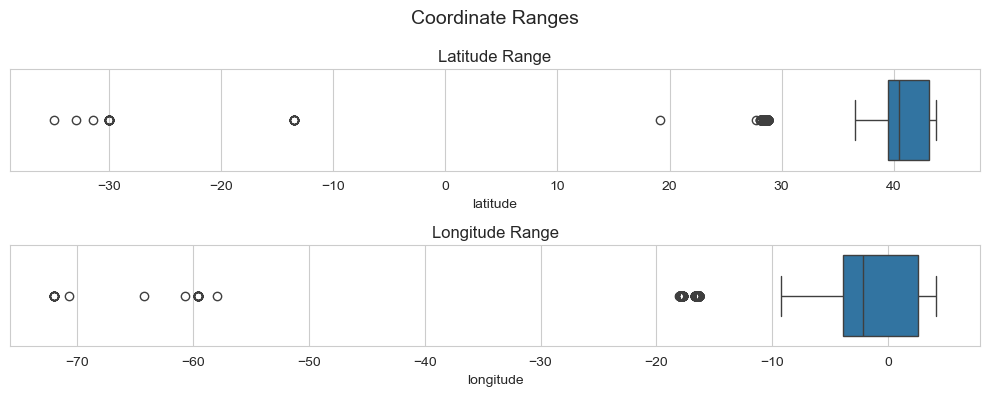

In [36]:
fig, ax = plt.subplots(2,1, figsize=(10, 4))

sns.boxplot(x=processed_data['latitude'], ax=ax[0])
ax[0].set_title('Latitude Range')

sns.boxplot(x=processed_data['longitude'], ax=ax[1])
ax[1].set_title('Longitude Range')

fig.suptitle('Coordinate Ranges', fontsize=14)
plt.tight_layout()
plt.show()

#### Remove Invalid Records

In [37]:
# Counting Invalid Records in longitude
outliers_longitude = processed_data[processed_data['longitude'] < -20.0]
count = outliers_longitude['longitude'].value_counts().sum()
print(f"The dataframe has {int(count)} longitude records out of range")

The dataframe has 37 longitude records out of range


In [39]:
# Remove records out of range (< -20.0)
processed_data = processed_data[processed_data['longitude'] >= -20]

In [40]:
# Verifying
print(f"Latitude: Min = {processed_data['latitude'].min()}, Max = {processed_data['latitude'].max()}")
print(f"Longitude: Min = {processed_data['longitude'].min()}, Max = {processed_data['longitude'].max()}")

Latitude: Min = 27.7254993, Max = 43.77288
Longitude: Min = -18.024301, Max = 4.109625448313687


#### Removing Regions with Insufficient Data

In [46]:
processed_data['region'].value_counts()

region
Islas Baleares          24123
País Vasco              23549
Galicia                  9792
Andalucía                6398
Castilla y León          6034
Castilla-La Mancha       6028
Comunidad de Madrid      5170
Cataluña                 4305
Comunidad Valenciana     3303
Canarias                 1185
Extremadura                 7
La Rioja                    5
Aragón                      3
Región de Murcia            2
Barcelona                   2
Gerona                      2
Gijón                       1
Navarra                     1
Piloña                      1
Name: count, dtype: int64

In [47]:
# Eliminate records
region_counts = processed_data['region'].value_counts()
regions_to_keep = region_counts[region_counts > 7].index
processed_data = processed_data[processed_data['region'].isin(regions_to_keep)]

In [48]:
# Verifying
processed_data['region'].value_counts()

region
Islas Baleares          24123
País Vasco              23549
Galicia                  9792
Andalucía                6398
Castilla y León          6034
Castilla-La Mancha       6028
Comunidad de Madrid      5170
Cataluña                 4305
Comunidad Valenciana     3303
Canarias                 1185
Name: count, dtype: int64

#### Filtering House Types

In this analysis, we are focused on studying family homes. Therefore, we will exclude housing types that do not meet this definition, such as rural homes or those with characteristics that do not align with the concept of a typical family residence.

Types of Housing to be Analyzed

- **Apartment**: A dwelling within a multi-unit building. Although it’s not a standalone house, it is a valid option for families seeking affordable housing in urban areas.
- **Single-Family Home**: The most classic example of a family home. It is a detached house meant for a single family. Another term for this is "Chalet"
- **Townhouse**: A single-family home that shares walls with other houses, but each unit is separate. It is common in urban and suburban areas.
- **Cottage** is typically a small house for families, often modest and traditional, featuring a rustic and functional design. They are commonly used as holiday homes.
- **Duplex**: In Spain, a duplex refers to a type of 'Single-Family Home' that has two floors connected by an internal staircase or an elevator. Another term for this is "Chalet Duplex".
- **Semi-Detached House**: Similar to a duplex, but designed to house two families in separate homes divided by a single shared wall.

In [49]:
processed_data['house_type'].value_counts()

house_type
Apartment              50777
Single-Family Home     19672
Townhouse               6123
Cottage                 3014
Farmhouse               2551
Duplex                  2537
Semi-Detached House     2463
Rural House             1611
Studio Apartment         800
Mansion                  128
Country House             98
Bungalow                  56
Ranch House               29
Tower House               19
Palace                     8
Castle                     1
Name: count, dtype: int64

In [50]:
house_types_to_exclude = ['Farmhouse', 'Rural House', 'Studio Apartment', 'Mansion', 'Country House', 'Bungalow', 'Ranch House', 'Tower House', 'Palace', 'Castle']
processed_data = processed_data[~processed_data['house_type'].isin(house_types_to_exclude)]
# Verifying
processed_data['house_type'].value_counts()

house_type
Apartment              50777
Single-Family Home     19672
Townhouse               6123
Cottage                 3014
Duplex                  2537
Semi-Detached House     2463
Name: count, dtype: int64

#### Group by price segments

The new variable `price_segment` is obtained by grouping properties into three price categories — **Affordable**, **Mid-Range**, and **Luxury**. This will allow for a better understanding of the differences within each segment, enable more specific analyses, and allow for a more focused treatment of outliers within each price range.

Price range for categorizing property prices:
- **Affordable**: For properties with accessible prices: up to €300,000.
- **Mid-Range**: For properties with moderate prices: from €300,000 to €700,000.
- **Luxury**: For properties with high prices: over €700,000. 

In [51]:
# Ranges and labels
bins = [0, 300000, 700000, float('inf')]
labels = ['Affordable', 'Mid-Range', 'Luxury']

In [52]:
# Create the categorical variable
processed_data.loc[:, 'price_segment'] = pd.cut(processed_data['price'], bins=bins, labels=labels, ordered=True)

In [ ]:
# Housing type information by price segment
count_df = processed_data.groupby(['price_segment', 'house_type'], observed=False).size().unstack(fill_value=0)
count_df

### Handling Outliers

#### Rooms

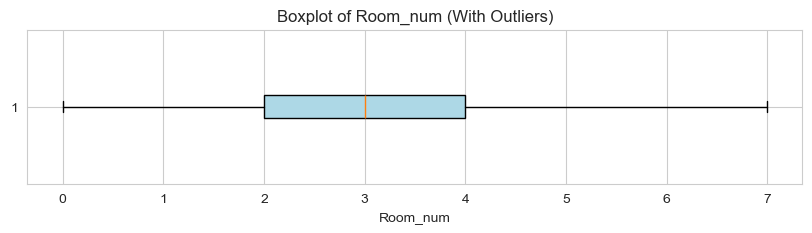

In [57]:
boxplot_view(processed_data, 'room_num')

In [58]:
processed_data['room_num'].value_counts().sort_index()

room_num
0      359
1     5074
2    18217
3    34219
4    16826
5     6615
6     2386
7      890
Name: count, dtype: int64

In [59]:
# Remove records where rooms is equal to 0.
processed_data = processed_data[processed_data['room_num'] != 0]

In [60]:
# Verifying
processed_data['room_num'].value_counts().sort_index()

room_num
1     5074
2    18217
3    34219
4    16826
5     6615
6     2386
7      890
Name: count, dtype: int64

#### bathrooms

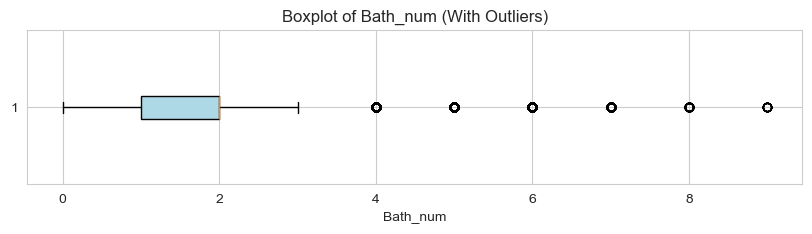

In [61]:
boxplot_view(processed_data, 'bath_num')

Discover in which price segments the outliers are located.

In [65]:
count_df = processed_data.groupby(['price_segment', 'bath_num'], observed=False).size().unstack(fill_value=0)
count_df

bath_num,0,1,2,3,4,5,6,7,8,9
price_segment,,,,,,,,,,
Affordable,144,28801,24051,3711,453,58,12,9,1,1
Mid-Range,5,2323,9138,5025,1626,355,70,8,4,1
Luxury,1,163,2109,2730,1966,952,366,99,36,9


Remove records with a value of 0.

In [66]:
processed_data = processed_data[processed_data['bath_num'] != 0]
processed_data['bath_num'].value_counts().sort_index()

bath_num
1    31287
2    35298
3    11466
4     4045
5     1365
6      448
7      116
8       41
9       11
Name: count, dtype: int64

#### Price

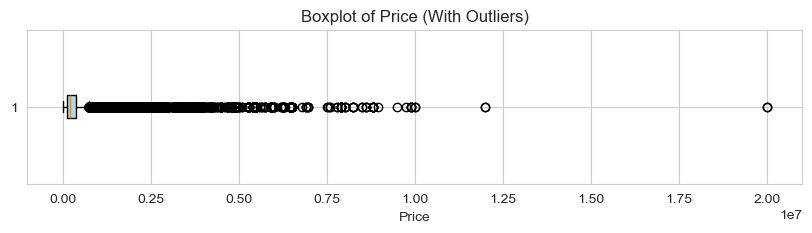

In [67]:
boxplot_view(processed_data, 'price')

In [68]:
print(processed_data['price'].describe())

count    8.407700e+04
mean     3.507700e+05
std      5.298668e+05
min      1.000000e+00
25%      1.200000e+05
50%      2.030000e+05
75%      3.750000e+05
max      2.000000e+07
Name: price, dtype: float64


Upon examining the distribution of the `price` variable, a significant dispersion is observed between the extreme values and the quartiles (minimum and 25%, as well as 75% and maximum). This disparity distorts data representation and may influence statistical and visual results. An initial trimming of the `price` variable will be conducted by setting a minimum threshold of 10,000 and a maximum of 2 million for property prices.

In [69]:
# trimming outliers
processed_data = processed_data[(processed_data['price'] >= 10000) & (processed_data['price'] <= 2000000)]

In [70]:
print(processed_data['price'].describe())

count    8.278000e+04
mean     3.039853e+05
std      3.051875e+05
min      1.000000e+04
25%      1.200000e+05
50%      2.000000e+05
75%      3.605000e+05
max      2.000000e+06
Name: price, dtype: float64


#### Square meters

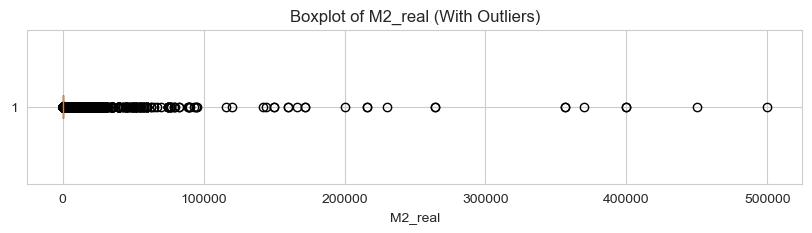

In [71]:
boxplot_view(processed_data, 'm2_real')

In [72]:
print(processed_data['m2_real'].describe())

count     82780.000000
mean        629.562370
std        5340.065022
min           1.000000
25%          80.000000
50%         110.000000
75%         210.000000
max      500000.000000
Name: m2_real, dtype: float64


The distribution of the *m2_real* variable shows minimum values that do not correspond to realistic data and may influence statistical and visual results. An initial trimming will be applied, setting a minimum of 20 square meters. Extreme maximum values will not be removed, these will be removed later by specific segments.

In [73]:
# trimming minimum outliers
processed_data = processed_data[processed_data['m2_real'] >= 20]
# verifying
print(f"Minimum value for m2_real variable: {processed_data['m2_real'].min()}")

Minimum value for m2_real variable: 20


#### Property Size Classification by Square Footage

To provide a more accurate analysis, we classify properties into three size segments based on their actual square footage: Small, Medium, and Large.

The ranges used for each segment are as follows:

- **Small**: Up to 93 m², ideal for apartments, townhouses, or compact homes in urban areas.
- **Medium**: Between 93 m² and 232 m², commonly suitable for single-family homes in suburban areas.
- **Large**: More than 232 m², expansive properties with additional land.

In [74]:
# define ranges and labels
bins = [0, 93, 232, float('inf')]
labels = ['Small', 'Medium', 'Large']

# create new variable
processed_data['size_category'] = pd.cut(processed_data['m2_real'], bins=bins, labels=labels, right=False, ordered=True)

In [75]:
# verifying
print(processed_data['size_category'].cat.categories)
processed_data['size_category'].value_counts()

Index(['Small', 'Medium', 'Large'], dtype='object')


size_category
Medium    33346
Small     30285
Large     19101
Name: count, dtype: int64

#### Removing Outliers Using the IQR Criterion

The following functions perform outlier cleaning, taking into account how each variable behaves within a segment defined by region, housing type, and price segment.

- The **remove_outliers** function applies the interquartile range (IQR) criterion to detect and remove outliers that fall outside this range (values less than Q1 - 1.5 * IQR or greater than Q3 + 1.5 * IQR).

- The **clean_outliers_by_segment** function uses the previous function within each defined segment.

The cleaned data for each subgroup are then concatenated into a new dataframe, which is returned at the end of the process.

In [76]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_filtered


def clean_outliers_by_segment(df, price_segment_column, house_type_column, region_column, column_to_clean):
    filtered_df = pd.DataFrame()

    # filter by price_segment
    for segment in df[price_segment_column].unique():
        df_segment = df[df[price_segment_column] == segment]

        # Filtrar por house_type dentro de cada price_segment
        for house_type in df_segment[house_type_column].unique():
            df_house_type = df_segment[df_segment[house_type_column] == house_type]

            # Filtrar por region dentro de cada house_type y aplicar el filtro de outliers
            for region in df_house_type[region_column].unique():
                df_region = df_house_type[df_house_type[region_column] == region]

                # Aplicar la eliminación de outliers en la columna específica (e.g. m2_real)
                df_cleaned = remove_outliers(df_region, column_to_clean)

                # Concatenar los resultados
                filtered_df = pd.concat([filtered_df, df_cleaned])

    return filtered_df

In [77]:
spain_housing = clean_outliers_by_segment(processed_data, 'price_segment', 'house_type', 'region', 'm2_real')

In [78]:
# Verifying
spain_housing.describe().T

,count,mean,std,min,25%,50%,75%,max
air_conditioner,77735.0,0.243854,0.429409,0.000000,0.000000,0.000000,0.000000,1.000000e+00
bath_num,77735.0,1.877430,0.923016,1.000000,1.000000,2.000000,2.000000,9.000000e+00
chimney,77735.0,0.014884,0.121089,0.000000,0.000000,0.000000,0.000000,1.000000e+00
garden,77735.0,0.263897,0.440747,0.000000,0.000000,0.000000,1.000000,1.000000e+00
m2_real,77735.0,255.375558,510.132655,20.000000,80.000000,105.000000,183.000000,2.700000e+04
price,77735.0,295822.554049,297050.870586,10000.000000,120000.000000,195500.000000,354428.000000,2.000000e+06
room_num,77735.0,3.079141,1.132914,1.000000,2.000000,3.000000,4.000000,7.000000e+00
storage_room,77735.0,0.422075,0.493894,0.000000,0.000000,0.000000,1.000000,1.000000e+00
swimming_pool,77735.0,0.178169,0.382658,0.000000,0.000000,0.000000,0.000000,1.000000e+00
terrace,77735.0,0.483296,0.499724,0.000000,0.000000,0.000000,1.000000,1.000000e+00


### Saving the dataframe ready for statistical analysis.

In [ ]:
# spain_housing.to_csv('data/spain_housing.csv', index=False)
del spain_housing
gc.collect()